# Distribute Placements

### Now we wish to distribute placements over the eligible areas, after the exclusion of ineligibilities.
### You will learn how to distribute point placements or area polygons and what the impact of different spacings can be. You will also save placements to view them e.g. in QGIS and calculate power densities based on your placement distribution.

## Import required packages

In [1]:
import glaes as gl
import geokit as gk
import os
import pathlib

## Define input and output paths and filenames

In [2]:
# NOTE: The results folder exists in your repo under /student_files/results/, but the files created therein will not be pushed back to git

# this is the current working directory ("student_files/exercises")
cwd = pathlib.Path().cwd()
print(f"Current working directory: {cwd}")

# the results folder is in "student_files/results", so go "2 folders up"
results_folder = os.path.join(os.path.dirname(os.path.dirname(cwd)), 'results')
# make sure folder exists
assert os.path.isdir(results_folder), f"results folder does not exist: '{results_folder}'"

print(f"Results folder:", results_folder)

Current working directory: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/exercises/Unit_04_LandEligibilityForVolatileRenewableEnergySources
Results folder: /storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results


In [3]:
region_shp = r"region_shapefiles/COUNTRY_gadm_shapes_GID_level_1.shp"
WSF2019_basename = r"REGION_extract_WSF2019_clipped_resampled.tif"

In [4]:
# just like before, we determine our datafolder, here in a one liner
data_basefolder = os.path.join(os.path.dirname(os.path.dirname(cwd)), 'data')
print(data_basefolder)

/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data


## Prepare the ec object

<Axes: >

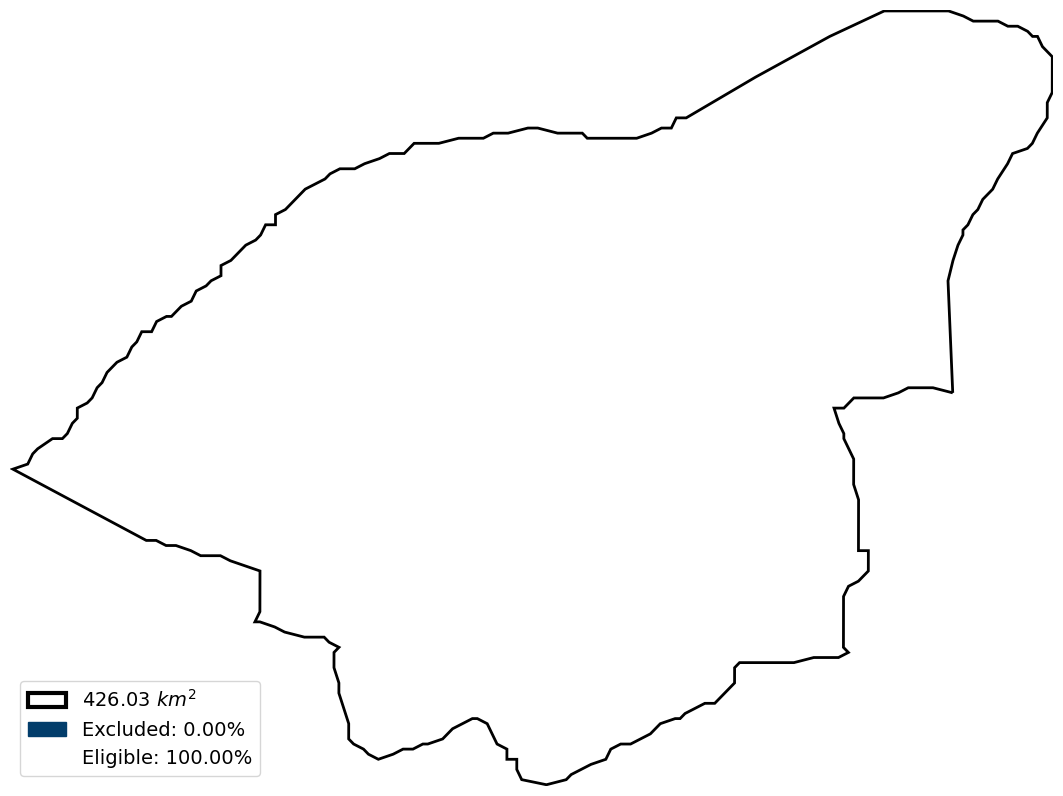

In [5]:
# define main params
region = 'NER.5_1'
resolution = 100

# country code is the first 3 characters of the region code
country = region[:3]

# create an ec object with a metric EPSG, here 3857 centered on lat/lon 0/0 (see: https://epsg.io/3857 )
ec = gl.ExclusionCalculator(
    region=os.path.join(data_basefolder, region_shp.replace("COUNTRY", country)),
    where=f"GID_1 = '{region}'",
    srs=gk.srs.EPSG3857,
    pixelRes=resolution,
)
# draw the resulting ec object
ec.draw()

## Apply exemplary exclusion

AxHands(ax=<Axes: >, handles=<matplotlib.image.AxesImage object at 0x7f8f38728b50>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f8f38728f10>)

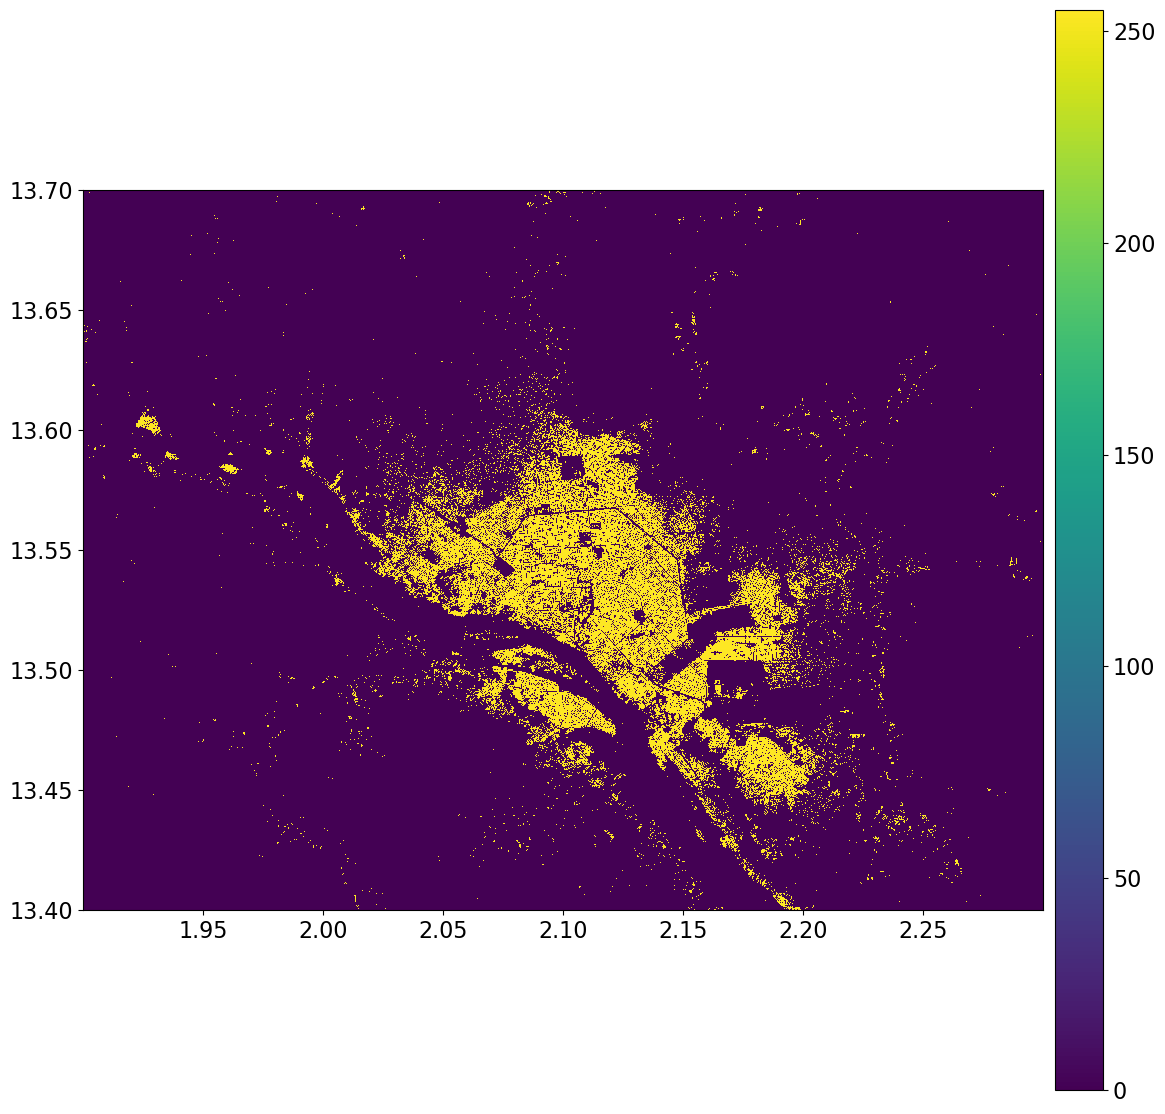

In [6]:
gk.drawRaster("/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/data/exclusion_datasets//WSF2019//NER//NER.5_1_extract_WSF2019_clipped.tif")

Memory useage during calc: 309.8203125 MB


<Axes: >

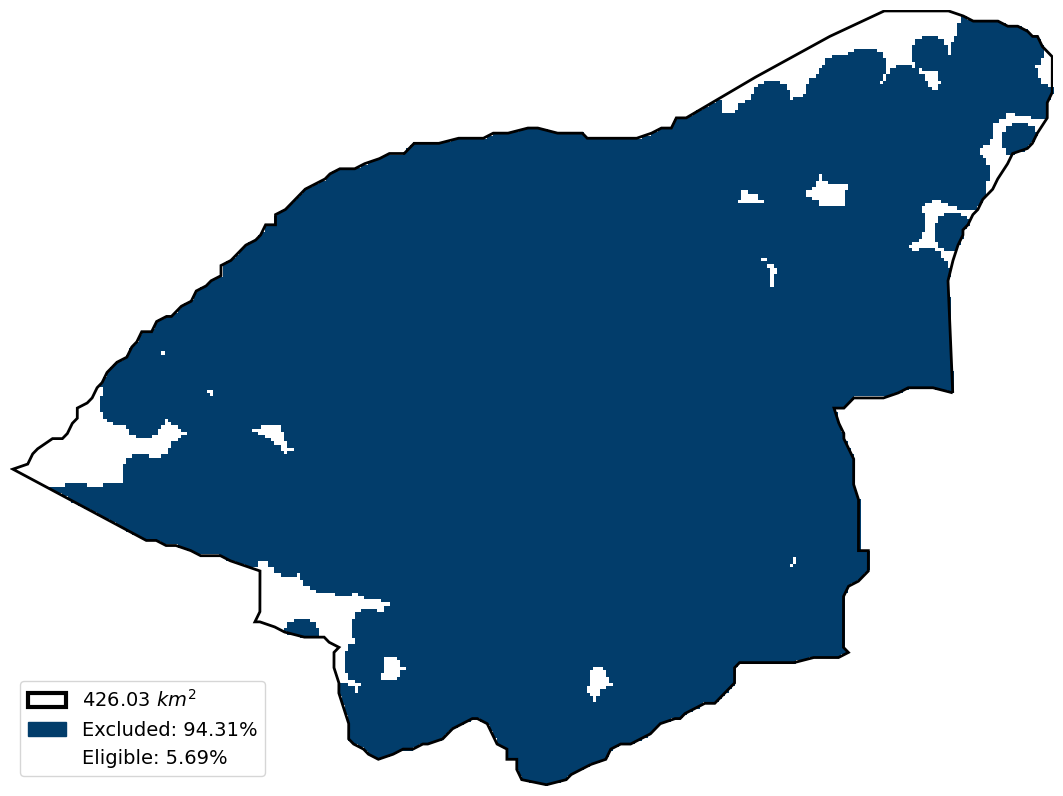

In [7]:
# just to show the concept, we apply only ONE random exclusion here
# usually you would first apply ALL exclusions before distributing placements over the remaining eligible land!

ec.excludeRasterType(
    source=os.path.join(results_folder, WSF2019_basename.replace("REGION", region)),
    value=255, 
    resampleAlg='max', # note the max resampleAlg
    buffer=500, # 500m is just selected randomly here
)
# show the results
ec.draw()

In [8]:
# our remaining available/eligible area is as follows, always in the unit of the srs, hence m²:
ec.areaAvailable

24260000.0

<Axes: >

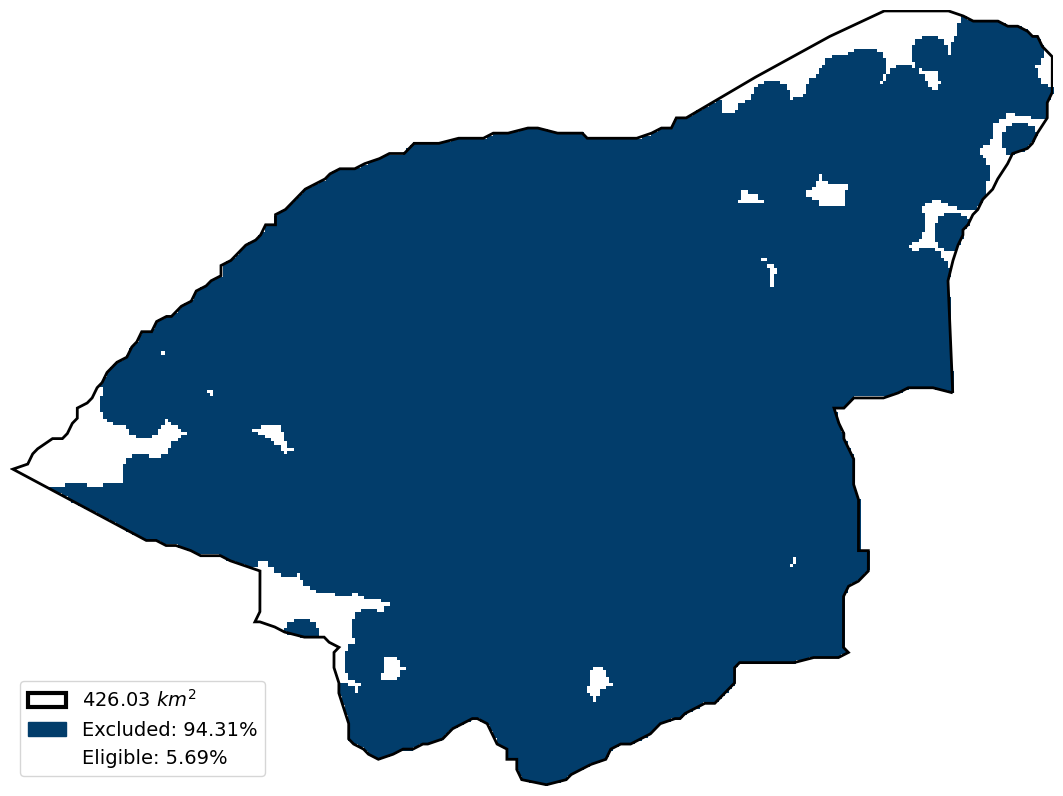

In [9]:
# we will now create a COPY of this ec object so we can apply placement distribution repeatedly to the same pre-excluded ec object

from copy import copy # usually you would import this at the beginning, only to show how it works here
ec_backup = copy(ec)

# draw ec_backup, you see, it is the same ec object
ec_backup.draw()

## Distribute Placements

<Axes: >

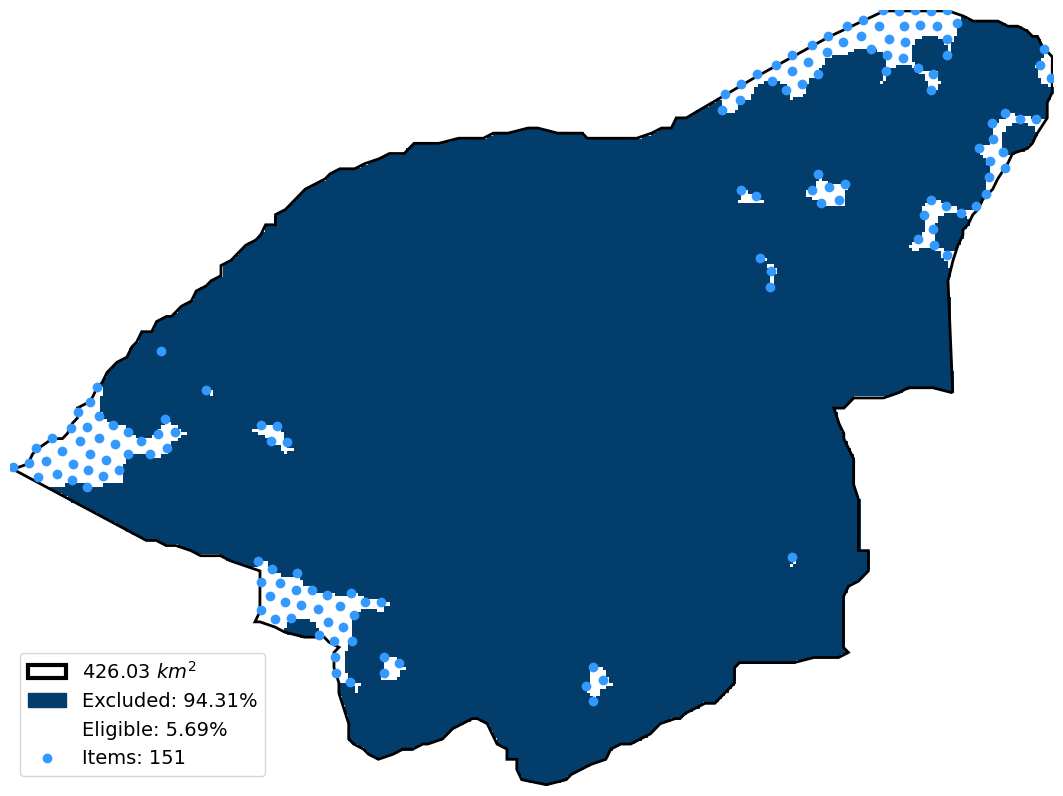

In [10]:
# we first distribute points, with a separation spacing of 500m
ec.distributeItems(separation=500)

# note the points spaced evenly across all eligible areas below
# in the legend, we also see the number of items that we could place
ec.draw()

<Axes: >

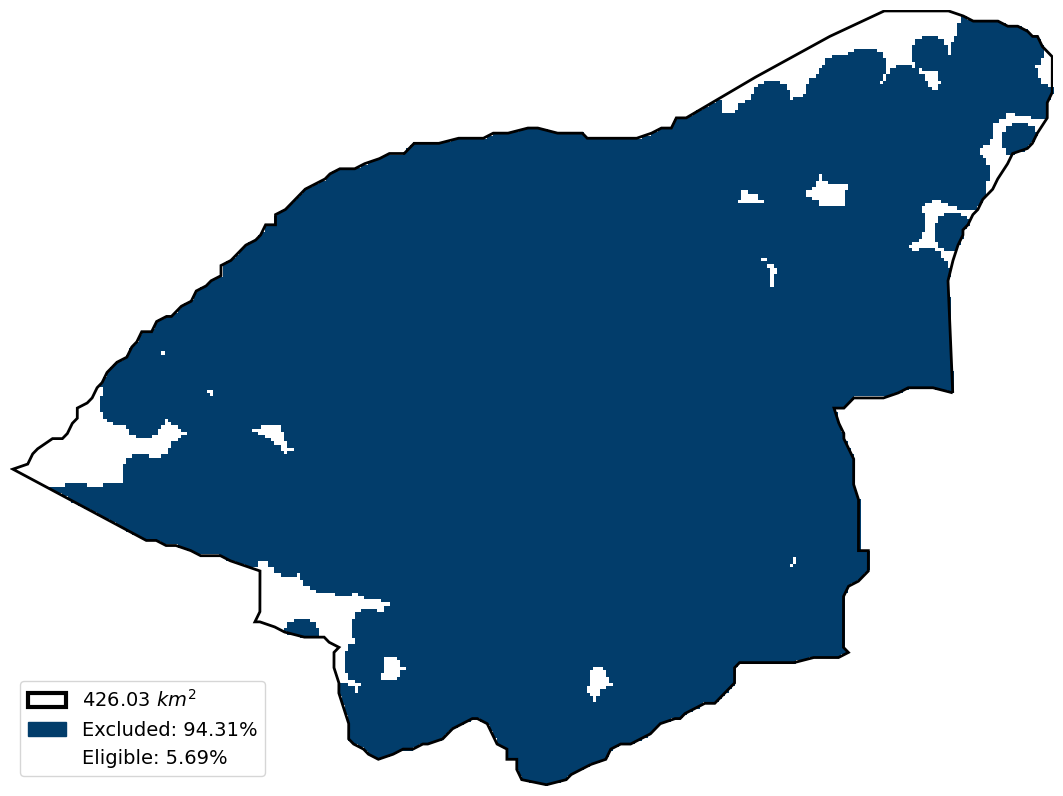

In [11]:
# now, we set the ec object back to the status of the ec_backup, when no points where distributed yet
# this works easily by overwriting our ec variable with a copy again of ec_backup

ec = copy(ec_backup)
# see that the points are gone again
ec.draw()

<Axes: >

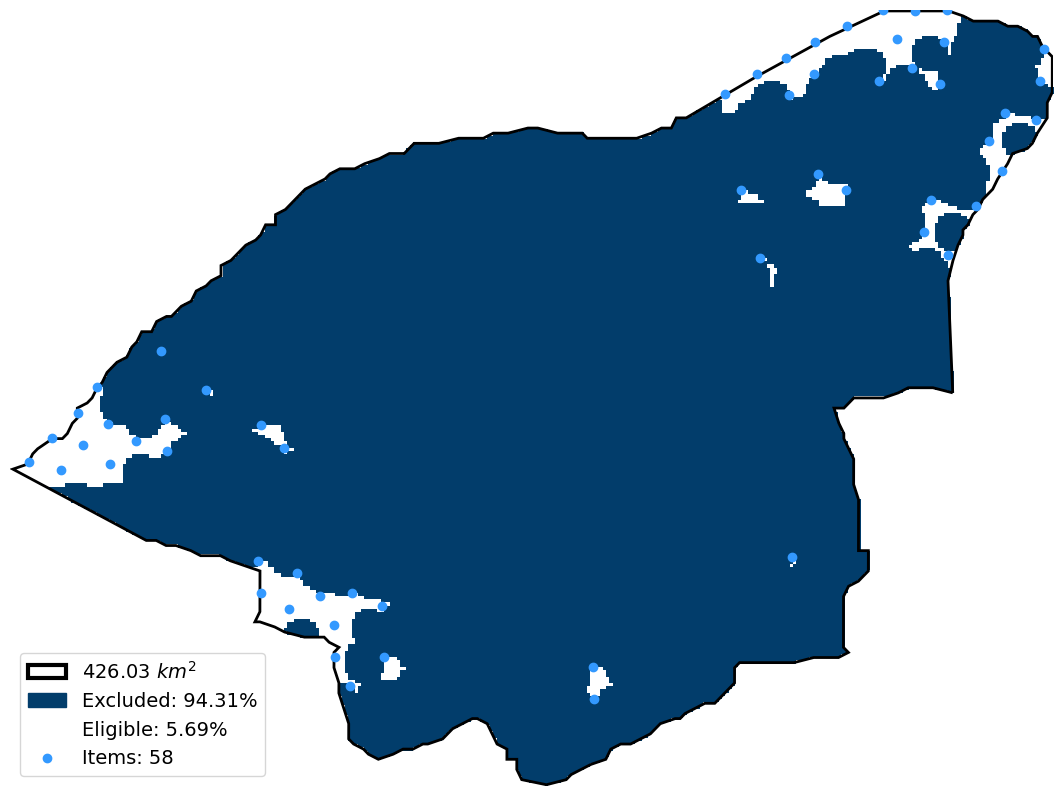

In [12]:
# we distribute points again, now as a test with a different separation spacing of 1500m
# NOTE that it is also possible to apply different spacings in downwind and crosswind directions
ec.distributeItems(separation=1000)

# note that we have way less points now
ec.draw()

In [13]:
# we can also extract the number of placements by getting the length of the item coordinates array
len(ec.itemCoords)

58

In [14]:
# we can now extract the points
ec.saveItems(
    output=os.path.join(results_folder, 'placements_wind_1000m_separation.shp'),
    srs=gk.srs.EPSG4326, # use a standard lat/lon SRS to save your data
) 

# you can go to the shapefile in your results folder now (if you wish) and check the turbine locations in QGIS

'/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results/placements_wind_1000m_separation.shp'

## Now distribute areas
#### For e.g. PV plants, we do not need only point locations but instead, we need an area polygon to determine capacity (since capacity is near linear with area for open-field PV plants)

<Axes: >

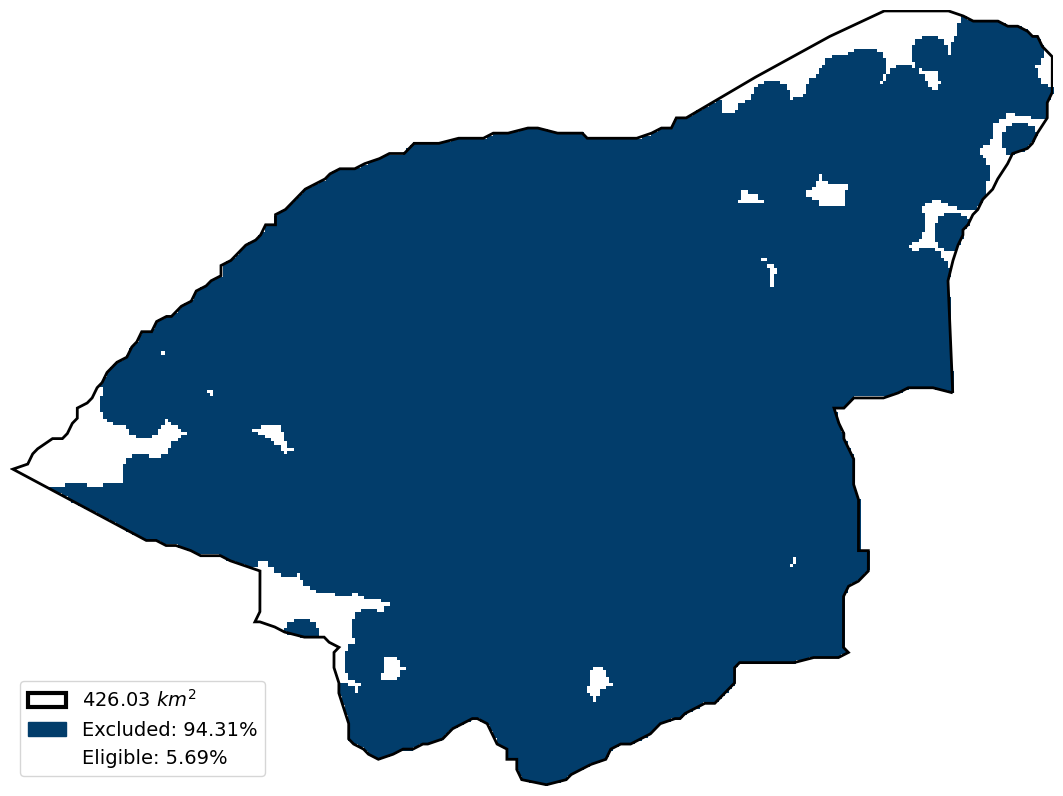

In [15]:
# we assume that also in this (exemplary) case, only settlements need to be excluded with 500m buffer (hence the same exclusions as above for wind, which is different in reality!)
# therefore, we first set the ec object back to the status of the ec_backup, when no points where distributed yet
ec = copy(ec_backup)

# see that the points are gone again
ec.draw()

<Axes: >

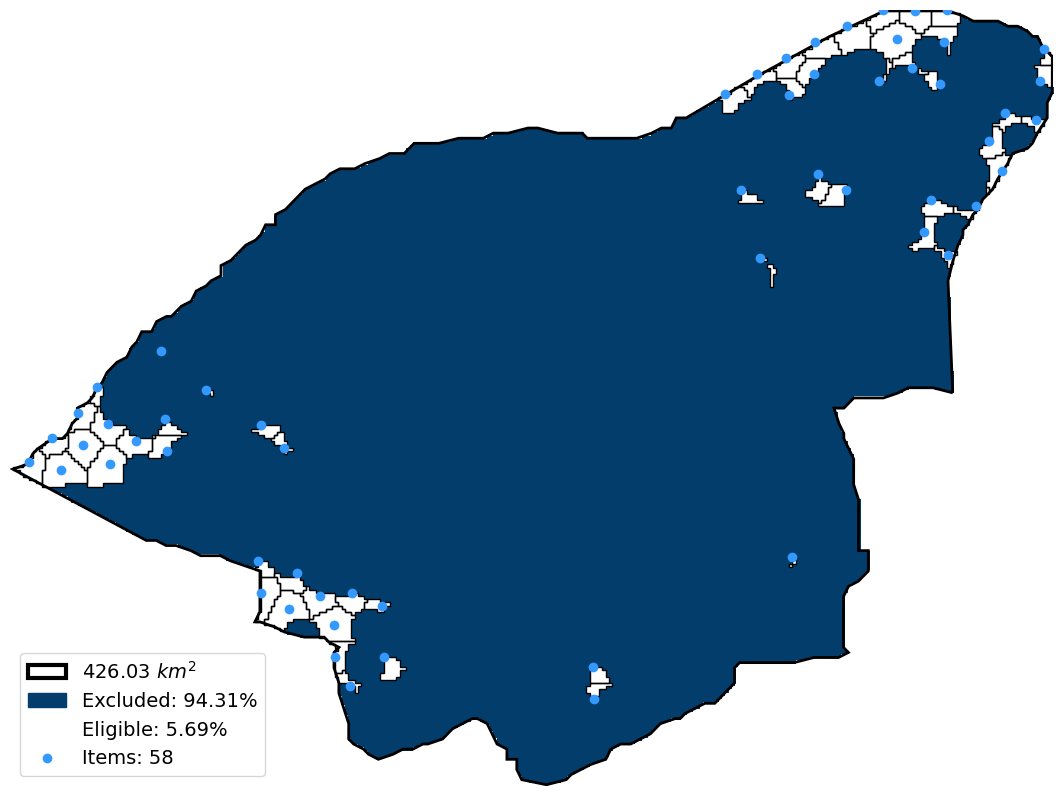

In [16]:
# even for open field PV plants, we first need to distribute points
# these serve as center points for our PV plants, around which optimal PV plant polygons will then be created as so called "Voronoi polygons"

# NOTE: as a separation distance for open-field pv, 1000m yields reealistic maximum PV plant sizes
ec.distributeItems(separation=1000)

# around these points, we now spread our area polygons
# therefore, we apply the method ec.distributeAreas()
ec.distributeAreas(
    minArea=10000, # this value in m² is the minimum size that one plant must have. 
    # It allows to filter out economically non viable plants due to small size when using very fine resolutions
    # Play around with it and watch closely, the black lines will disappear for the smalles patches when you increase this value
)

# show what we have now
ec.draw()
# you can see the center points and the area polygons as fine lines

In [17]:
# save these polygons to disk as well
ec.saveAreas(
    output=(os.path.join(results_folder, 'placements_solar.shp')),
    srs=gk.srs.EPSG4326, # use a standard lat/lon SRS to save your data
)

'/storage_cluster/projects/2025_c-winkler_IMP-EGH/imp_egh_ice-2_v2024-25/student_files/results/placements_solar.shp'

# TASK: Calculate the power density for the above study region with settlements exclusion (buffer 500m) and a spacing of 8x rotor diameter; see task definition for assumed turbine type

<Axes: >

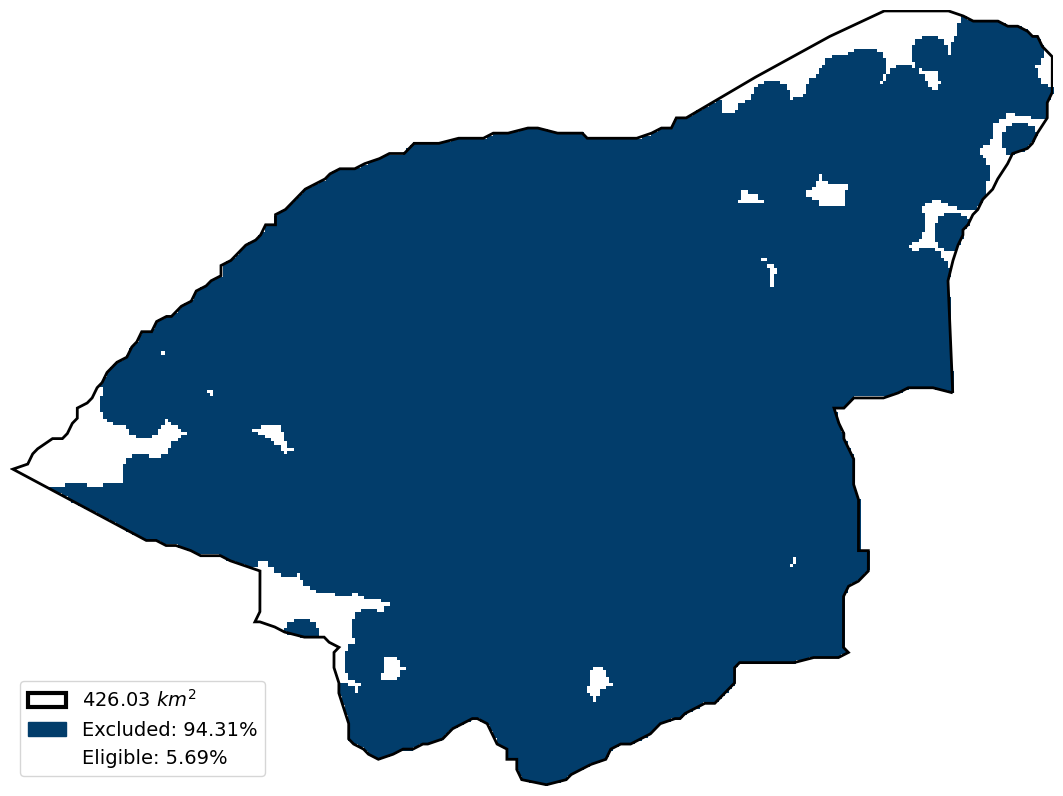

In [18]:
# we would now have to create a new exc object for the study region and exclude houses with 500m buffer
# by chance, this is the exact exclusion that was applied above! we can hence use our ec_backup again
ec = copy(ec_backup)
ec.draw()

<Axes: >

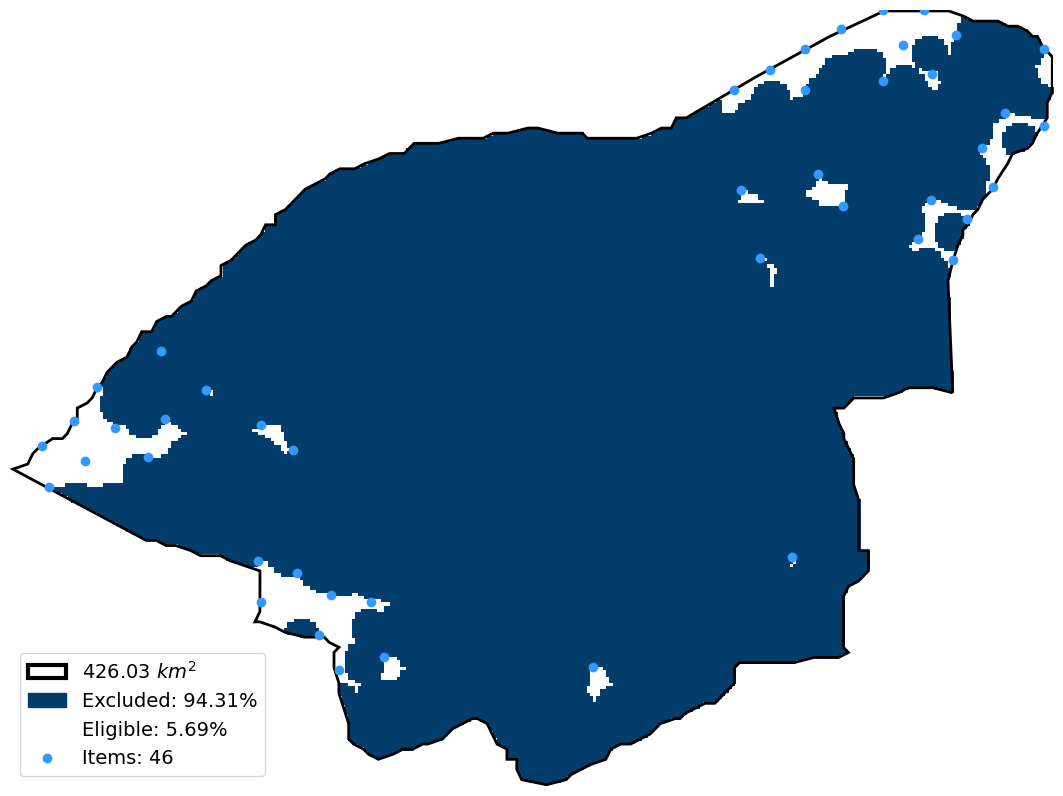

In [19]:
# the defined turbine type has a rotor diameter of 158m, with a required spacing of 8x diameter, the spacing is 1264 m
ec.distributeItems(separation=1264)
ec.draw()

In [20]:
# we now wish to know what total capacity = wind power we can install
# our capacity per turbine is given as 5.5 MW
capacity_per_turbine_MW = 5.5

# to get the whole regional capacity, we need to extract the number of placements and multiply it with the individual turbine power
regional_capacity = len(ec.itemCoords) * capacity_per_turbine_MW

# the regional capacity in MW
print(f"The total installable capacity in our study region is {regional_capacity} MW.")

The total installable capacity in our study region is 253.0 MW.


In [21]:
# however, the task requested the power density in MW/km²
# therefore, we first need the eligible area in km², we need to convert from m²
areaAvailable_km2 = ec.areaAvailable/(1000**2)

# our available area
print(f"The available area in the study region is {areaAvailable_km2} km².")

The available area in the study region is 24.26 km².


In [22]:
# as a last step, we calculate the power density by dividing the installable capacity by the eligible land area
power_density_MWpkm2 = regional_capacity/areaAvailable_km2

print(f"The regional power density under the given circumstances is {round(power_density_MWpkm2,1)} MW/km².")

# This value is medium to quite high, compared to the European, global and African values you have seen in the lecture
# Reason is probably that the excluded settlements are quite distributed and small eligible patches allow for an efficient usage of space when building turbines
# This value would even be higher if the settlements were even more distributed, this is not the case in a capital region though

The regional power density under the given circumstances is 10.4 MW/km².
